# Covid-19 Prediction Using World Development Indicators (WDI)

The Covid-19 pandemic have had devastating outcomes for many countries around the world. To mitigate the mortality and morbidity rates of the pandemic, forecasting models are needed. Since countries are structurally diverse, the unique country characteristics should be accounted for while making a predictive model (Nikolopoulos et al., 2020). To measure the extent of the predictive power of unique country characteristics I am asking the following question: Can World Development Indicators (WDI) predict Deaths resulting from Covid-19? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import warnings
from pandas_datareader import wb 
import random
import seaborn as sns
sns.set()
import geopandas as gpd
import datetime as dt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import math
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
import plotly.graph_objects as go
from matplotlib import pyplot

%matplotlib inline

/Users/anahitaainy/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


## Data

For this project, I am combining data from two sources. The first dataset I am using is obtained from Johns Hopkins University and contains the number of daily Covid-19 confirmed cases, deaths, recoveries, latitude and longitude for every country from the time period of January 22, 2020 to December 7, 2020 (Johns Hopkins University, 2020). The second dataset I am using is World Development Indicators (WDI) data which is one of the World Bank’s primary compilation of cross-country comparable data on development. I am using the World Bank indicator API to get access to 1,400 time-series development indicators. <br>

To answer my research question, I use total Covid-19 deaths as the target variable and World Development Indicators (WDI) as the predictor variables. These specific indicators are chosen since they are some of the most common indicators of development, and they embrace the three main dimensions of development: economic, social and environmental (McGranahan, 1972). After accessing the WDIs using the World Bank indicator API, I use the most recent non-missing values for each development indicator in order to merge them with the Covid-19 dataset. One thing I have considered before merging the datasets is that some countries are named differently in the datasets. Therefore, I have matched the country names to make sure that some countries do not get eliminated in the process. After making adjustments to the country names, I combine the two datasets together. This resulting dataset is a panel time-series dataset of 191 countries from January 22, 2020 to December 7, 2020 and contains data about Covid-19 deaths and indicators of development. 

### Johns Hopkins University

In [2]:
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

ids = ["Province/State","Country/Region", "Lat","Long"]
confirmed=confirmed.melt(id_vars=ids, var_name="Date", value_name="cases")
deaths=deaths.melt(id_vars=ids,var_name="Date", value_name="deaths")
recoveries=recoveries.melt(id_vars=ids,var_name="Date", value_name="recoveries")

covid = pd.merge(confirmed, deaths, on=ids.append("Date"), how='outer')
covid = pd.merge(covid, recoveries, on=ids.append("Date"), how='left')

covid["Date"] = pd.to_datetime(covid["Date"])
covid["Province/State"]=covid["Province/State"].fillna("")

covid.groupby("Country/Region").get_group("Canada").groupby("Province/State").tail(1)
country=covid.groupby(["Country/Region","Date"]).sum().reset_index()

country = country[(country["Date"] < "2020-12-08")]
country


,Country/Region,Date,Lat,Long,cases,deaths,recoveries
0,Afghanistan,2020-01-22,33.939110,67.709953,0,0,0.0
1,Afghanistan,2020-01-23,33.939110,67.709953,0,0,0.0
2,Afghanistan,2020-01-24,33.939110,67.709953,0,0,0.0
3,Afghanistan,2020-01-25,33.939110,67.709953,0,0,0.0
4,Afghanistan,2020-01-26,33.939110,67.709953,0,0,0.0
...,...,...,...,...,...,...,...
67196,Zimbabwe,2020-12-03,-19.015438,29.154857,10424,280,8754.0
67197,Zimbabwe,2020-12-04,-19.015438,29.154857,10547,281,8802.0
67198,Zimbabwe,2020-12-05,-19.015438,29.154857,10617,291,8844.0
67199,Zimbabwe,2020-12-06,-19.015438,29.154857,10718,291,8880.0


### World Bank Data

In [4]:
ind_use = [
    # Population, total
    "SP.POP.TOTL",
    
    # GDP growth (annual %) 
    "NY.GDP.MKTP.KD.ZG",

    # Birth rate, crude (per 1,000 people)
    "SP.DYN.CBRT.IN",
    
    # Death rate, crude (per 1,000 people) (maybe)
    "SP.DYN.CDRT.IN",

    # Number of infant deaths
    "SH.DTH.IMRT",
    
    # Literacy rate, adult total (% of people ages 15 and above) 
    "SE.ADT.LITR.ZS",
    
    # Life expectancy at birth, total (years)
    "SP.DYN.LE00.IN", 
    
    # Physicians (per 1,000 people)
    "SH.MED.PHYS.ZS",
    
    # Household final consumption expenditure, PPP (current international $)
    "NE.CON.PRVT.PP.CD",
    
    # Poverty gap at $1.90 a day (2011 PPP) (%)
    "SI.POV.GAPS",
    
    # Women who believe a husband is justified in beating his wife (any of five reasons) (%) 
    "SG.VAW.REAS.ZS",
    
    # CPIA transparency, accountability, and corruption in the public sector rating (1=low to 6=high)
    "IQ.CPA.TRAN.XQ",
    
    # Unemployment, total (% of total labor force) (national estimate)
    "SL.UEM.TOTL.NE.ZS",
    
    # Urban population (% of total)
    "SP.URB.TOTL.IN.ZS",
    
    # Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)
    "SH.DTH.COMM.ZS", # maybe dont include
    
    # High-technology exports (% of manufactured exports)
    "TX.VAL.TECH.MF.ZS",
    
    # Prevalence of HIV, total (% of population ages 15-49)
    "SH.DYN.AIDS.ZS",
    ]

In [5]:
### API code: Econ 323
def fixcountrynames(s): # change country names
    trans = { "Egypt, Arab Rep.":"Egypt",
    "Slovak Republic":"Slovakia",
    "Brunei Darussalam":"Brunei",
    "United States":"US",
    "Iran, Islamic Rep.":"Iran",
    "Korea, Rep.":"Korea, South",
    "Czech Republic":"Czechia",
    "Russian Federation":"Russia",
    "Congo, Dem. Rep.":"Congo (Kinshasa)",
    "Venezuela, RB":"Venezuela",
    "St. Lucia":"Saint Lucia",
    "St. Vincent and the Grenadines":"Saint Vincent and the Grenadines",
    "Congo, Rep.":"Republic of the Congo",
    "Bahamas, The":"The Bahamas",
    "Gambia, The":"The Gambia"}
    for t in trans :
        s["Country/Region"] = s["Country/Region"].replace(t, trans[t])
    return(s)

wdi = covid.drop(columns=["Date","Province/State","Lat","Long","cases","deaths","recoveries"]).drop_duplicates()

for id in ind_use :
    s=wb.download(indicator=id, country="all", start=2005, end=2019).reset_index()

    # use most recent non missing value
    s=s.dropna().groupby("country").last()
    s=s.drop(columns="year").reset_index()

    # match country names to covid data
    s=s.rename(columns={"country":"Country/Region"})
    s=fixcountrynames(s)
    wdi=pd.merge(wdi, s, how='left', on='Country/Region', validate="one_to_one")


In [9]:
cvwdi=pd.merge(country, wdi, how='left', on="Country/Region", validate="many_to_one")
cvwdi

,Country/Region,Date,Lat,Long,cases,deaths,recoveries,SP.POP.TOTL,NY.GDP.MKTP.KD.ZG,SP.DYN.CBRT.IN,...,SH.MED.PHYS.ZS,NE.CON.PRVT.PP.CD,SI.POV.GAPS,SG.VAW.REAS.ZS,IQ.CPA.TRAN.XQ,SL.UEM.TOTL.NE.ZS,SP.URB.TOTL.IN.ZS,SH.DTH.COMM.ZS,TX.VAL.TECH.MF.ZS,SH.DYN.AIDS.ZS
0,Afghanistan,2020-01-22,33.939110,67.709953,0,0,0.0,25654277.0,11.229715,44.723,...,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1
1,Afghanistan,2020-01-23,33.939110,67.709953,0,0,0.0,25654277.0,11.229715,44.723,...,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1
2,Afghanistan,2020-01-24,33.939110,67.709953,0,0,0.0,25654277.0,11.229715,44.723,...,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1
3,Afghanistan,2020-01-25,33.939110,67.709953,0,0,0.0,25654277.0,11.229715,44.723,...,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1
4,Afghanistan,2020-01-26,33.939110,67.709953,0,0,0.0,25654277.0,11.229715,44.723,...,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61306,Zimbabwe,2020-12-03,-19.015438,29.154857,10424,280,8754.0,12076699.0,-5.711084,33.764,...,0.1255,1.847386e+10,5.2,47.7,1.5,5.3681,34.110,67.2,14.364183,17.6
61307,Zimbabwe,2020-12-04,-19.015438,29.154857,10547,281,8802.0,12076699.0,-5.711084,33.764,...,0.1255,1.847386e+10,5.2,47.7,1.5,5.3681,34.110,67.2,14.364183,17.6
61308,Zimbabwe,2020-12-05,-19.015438,29.154857,10617,291,8844.0,12076699.0,-5.711084,33.764,...,0.1255,1.847386e+10,5.2,47.7,1.5,5.3681,34.110,67.2,14.364183,17.6
61309,Zimbabwe,2020-12-06,-19.015438,29.154857,10718,291,8880.0,12076699.0,-5.711084,33.764,...,0.1255,1.847386e+10,5.2,47.7,1.5,5.3681,34.110,67.2,14.364183,17.6


### HDI Data

I have used the HDI data for visualization purposes. This data allows me to compare Covid-19 mortality for countries with different levels of development.

In [15]:
# https://worldpopulationreview.com/country-rankings/hdi-by-country

hdi = pd.read_csv("/Users/anahitaainy/Desktop/HDI_2020.csv")
hdi.columns = ["Country/Region", "HDI", "Population_2020"]
hdi = hdi.drop("Population_2020", axis = 1)
hdi.head()

,Country/Region,HDI
0,Norway,0.953
1,Switzerland,0.944
2,Australia,0.939
3,Ireland,0.938
4,Germany,0.936


In [16]:
# Finding the countries with different names in the dataset

cvwdi_countries = list(cvwdi["Country/Region"].unique())
hdi_countries = list(hdi["Country/Region"].unique())

difference = list(set(hdi_countries) - set(cvwdi_countries))
difference

['Ivory Coast',
 'Hong Kong',
 'Kiribati',
 'Palestine',
 'Turkmenistan',
 'Macedonia',
 'Czech Republic',
 'Republic of the Congo',
 'South Korea',
 'Swaziland',
 'Cape Verde',
 'Tonga',
 'United States',
 'Palau',
 'DR Congo',
 'Myanmar',
 'Micronesia']

In [17]:
# So, I will change the names of some countries in the dataset.

hdi.loc[hdi["Country/Region"] == "Ivory Coast", "Country/Region"] = "Cote d'Ivoire"
hdi.loc[hdi["Country/Region"] == "Myanmar", "Country/Region"] = "Burma"
hdi.loc[hdi["Country/Region"] == "Republic of the Congo", "Country/Region"] = "Congo (Brazzaville)"
hdi.loc[hdi["Country/Region"] == "South Korea", "Country/Region"] = "Korea, South"
hdi.loc[hdi["Country/Region"] == "DR Congo", "Country/Region"] = "Congo (Kinshasa)"
hdi.loc[hdi["Country/Region"] == "Swaziland", "Country/Region"] = "Eswatini"
hdi.loc[hdi["Country/Region"] == "Czech Republic", "Country/Region"] = "Czechia"
hdi.loc[hdi["Country/Region"] == "Macedonia", "Country/Region"] = "North Macedonia"
hdi.loc[hdi["Country/Region"] == "Palestine", "Country/Region"] = "West Bank and Gaza"
hdi.loc[hdi["Country/Region"] == "United States", "Country/Region"] = "US"
hdi.loc[hdi["Country/Region"] == "Cape Verde", "Country/Region"] = "Cabo Verde"

In [18]:
# Merging the data with hdi data
df = pd.merge(cvwdi, hdi, how = "left", on = "Country/Region", validate= "many_to_one")

# drop "lat" and "long"
df = df.drop(["Lat", "Long"], axis = 1)

# Renaming columns
df.columns = ["Country", "Date", "cases", "deaths", "recoveries", "Population(total)", "GDP_growth(annual %)", 
              "birth_rate", "death_rate", "number_of_infant_deaths", "literacy_rate(adults)",
              "life_expectancy_at_birth", "physicians(per 1000)", "household_consumption_expenditure",
              "poverty_gap", "justified_in_beating","CPIA_transparency","unemployment(total)", 
              "urban_population(% of total)", "death_by_diseases(% of total)",
              "high_technology_exports", "Prevalence of HIV", "HDI"]
df.head()

,Country,Date,cases,deaths,recoveries,Population(total),GDP_growth(annual %),birth_rate,death_rate,number_of_infant_deaths,...,household_consumption_expenditure,poverty_gap,justified_in_beating,CPIA_transparency,unemployment(total),urban_population(% of total),death_by_diseases(% of total),high_technology_exports,Prevalence of HIV,HDI
0,Afghanistan,2020-01-22,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498
1,Afghanistan,2020-01-23,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498
2,Afghanistan,2020-01-24,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498
3,Afghanistan,2020-01-25,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498
4,Afghanistan,2020-01-26,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498


In [19]:
# setting development levels
df["human_development_level"] = pd.cut(df["HDI"], bins = [0, 0.55, 0.7, 0.8, 1], include_lowest = True, right = False, 
       labels = ["low", "medium", 
                 "high", "very high"])
df.head()

,Country,Date,cases,deaths,recoveries,Population(total),GDP_growth(annual %),birth_rate,death_rate,number_of_infant_deaths,...,poverty_gap,justified_in_beating,CPIA_transparency,unemployment(total),urban_population(% of total),death_by_diseases(% of total),high_technology_exports,Prevalence of HIV,HDI,human_development_level
0,Afghanistan,2020-01-22,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low
1,Afghanistan,2020-01-23,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low
2,Afghanistan,2020-01-24,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low
3,Afghanistan,2020-01-25,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low
4,Afghanistan,2020-01-26,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low


In [86]:
# death rates (for visualization)
df["covid_death_rate"] = (df["deaths"]/df["cases"]) * 100
df

,Country,Date,cases,deaths,recoveries,Population(total),GDP_growth(annual %),birth_rate,death_rate,number_of_infant_deaths,...,justified_in_beating,CPIA_transparency,unemployment(total),urban_population(% of total),death_by_diseases(% of total),high_technology_exports,Prevalence of HIV,HDI,human_development_level,covid_death_rate
0,Afghanistan,2020-01-22,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low,NaN
1,Afghanistan,2020-01-23,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low,NaN
2,Afghanistan,2020-01-24,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low,NaN
3,Afghanistan,2020-01-25,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low,NaN
4,Afghanistan,2020-01-26,0,0,0.0,25654277.0,11.229715,44.723,10.003,85285.0,...,90.2,2.5,2.4945,22.703,50.2,NaN,0.1,0.498,low,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61306,Zimbabwe,2020-12-03,10424,280,8754.0,12076699.0,-5.711084,33.764,17.910,21293.0,...,47.7,1.5,5.3681,34.110,67.2,14.364183,17.6,0.535,low,2.686109
61307,Zimbabwe,2020-12-04,10547,281,8802.0,12076699.0,-5.711084,33.764,17.910,21293.0,...,47.7,1.5,5.3681,34.110,67.2,14.364183,17.6,0.535,low,2.664265
61308,Zimbabwe,2020-12-05,10617,291,8844.0,12076699.0,-5.711084,33.764,17.910,21293.0,...,47.7,1.5,5.3681,34.110,67.2,14.364183,17.6,0.535,low,2.740887
61309,Zimbabwe,2020-12-06,10718,291,8880.0,12076699.0,-5.711084,33.764,17.910,21293.0,...,47.7,1.5,5.3681,34.110,67.2,14.364183,17.6,0.535,low,2.715059


## Explanatory Data Analysis

In this section, I explore the data by performing an exploratory data analysis.

In [22]:
# number of rows and columns
df.shape

(61311, 25)

In [23]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61311 entries, 0 to 61310
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Country                            61311 non-null  object        
 1   Date                               61311 non-null  datetime64[ns]
 2   cases                              61311 non-null  int64         
 3   deaths                             61311 non-null  int64         
 4   recoveries                         61311 non-null  float64       
 5   Population(total)                  57138 non-null  float64       
 6   GDP_growth(annual %)               56817 non-null  float64       
 7   birth_rate                         57138 non-null  float64       
 8   death_rate                         57138 non-null  float64       
 9   number_of_infant_deaths            56496 non-null  float64       
 10  literacy_rate(adults)             

In [24]:
# Checking for missing values
df.isnull().sum()

Country                                  0
Date                                     0
cases                                    0
deaths                                   0
recoveries                               0
Population(total)                     4173
GDP_growth(annual %)                  4494
birth_rate                            4173
death_rate                            4173
number_of_infant_deaths               4815
literacy_rate(adults)                14445
life_expectancy_at_birth              5457
physicians(per 1000)                  5778
household_consumption_expenditure     8346
poverty_gap                          14124
justified_in_beating                 29853
CPIA_transparency                    36915
unemployment(total)                   7383
urban_population(% of total)          4494
death_by_diseases(% of total)         6741
high_technology_exports              12198
Prevalence of HIV                    24396
HDI                                   2568
human_devel

In [25]:
# Number of unique values 
df.nunique()

Country                                191
Date                                   321
cases                                24712
deaths                                8257
recoveries                           19607
Population(total)                      178
GDP_growth(annual %)                   177
birth_rate                             162
death_rate                             168
number_of_infant_deaths                173
literacy_rate(adults)                  146
life_expectancy_at_birth               174
physicians(per 1000)                   173
household_consumption_expenditure      165
poverty_gap                             81
justified_in_beating                    93
CPIA_transparency                        7
unemployment(total)                    164
urban_population(% of total)           175
death_by_diseases(% of total)          139
high_technology_exports                153
Prevalence of HIV                       41
HDI                                    158
human_devel

### Summary of Statistics for Covid-19 and the Selected WDIs

Descriptive statistics allows us to summarize data. For example, from the table below, we can see that there exists at least one country with 0 deaths, and there exists a country that has the highest cumulative deaths of 284,018. 

In [28]:
summary = df[["Country", "Date", "cases", "deaths", "recoveries", 
                     "Population(total)" ,"GDP_growth(annual %)", 
                     "birth_rate", "death_rate", "number_of_infant_deaths", "literacy_rate(adults)",
                     "life_expectancy_at_birth", "physicians(per 1000)", 
                     "household_consumption_expenditure", "poverty_gap", 
                     "justified_in_beating", "CPIA_transparency","unemployment(total)",
                     "urban_population(% of total)", "death_by_diseases(% of total)",
                     "high_technology_exports", "Prevalence of HIV"]].describe()
summary.transpose()

,count,mean,std,min,25%,50%,75%,max
cases,61311.0,9.463069e+04,5.767972e+05,0.000000e+00,2.900000e+01,1.763000e+03,2.120300e+04,1.503106e+07
deaths,61311.0,2.981983e+03,1.511355e+04,0.000000e+00,0.000000e+00,3.500000e+01,4.130000e+02,2.840180e+05
recoveries,61311.0,5.941730e+04,3.839034e+05,0.000000e+00,3.000000e+00,7.210000e+02,1.037100e+04,9.178946e+06
Population(total),57138.0,3.563666e+07,1.334993e+08,2.932400e+04,1.996114e+06,7.449877e+06,2.381618e+07,1.303720e+09
GDP_growth(annual %),56817.0,5.318994e+00,4.049641e+00,-1.312905e+01,3.018183e+00,4.942505e+00,7.093774e+00,2.796154e+01
birth_rate,57138.0,2.310482e+01,1.182994e+01,8.100000e+00,1.230000e+01,2.078700e+01,3.267800e+01,5.182000e+01
death_rate,57138.0,8.845496e+00,3.809562e+00,1.589000e+00,5.963000e+00,8.087000e+00,1.129300e+01,2.020400e+01
number_of_infant_deaths,56496.0,3.258012e+04,1.299628e+05,1.000000e+00,3.627500e+02,2.584000e+03,2.214350e+04,1.529523e+06
literacy_rate(adults),46866.0,7.984759e+01,2.204060e+01,2.352220e+01,6.603011e+01,8.982454e+01,9.796594e+01,9.999486e+01
life_expectancy_at_birth,55854.0,6.818642e+01,1.011834e+01,4.251800e+01,6.062000e+01,7.170650e+01,7.524463e+01,8.541707e+01


### Correlation Matrix and Heatmap

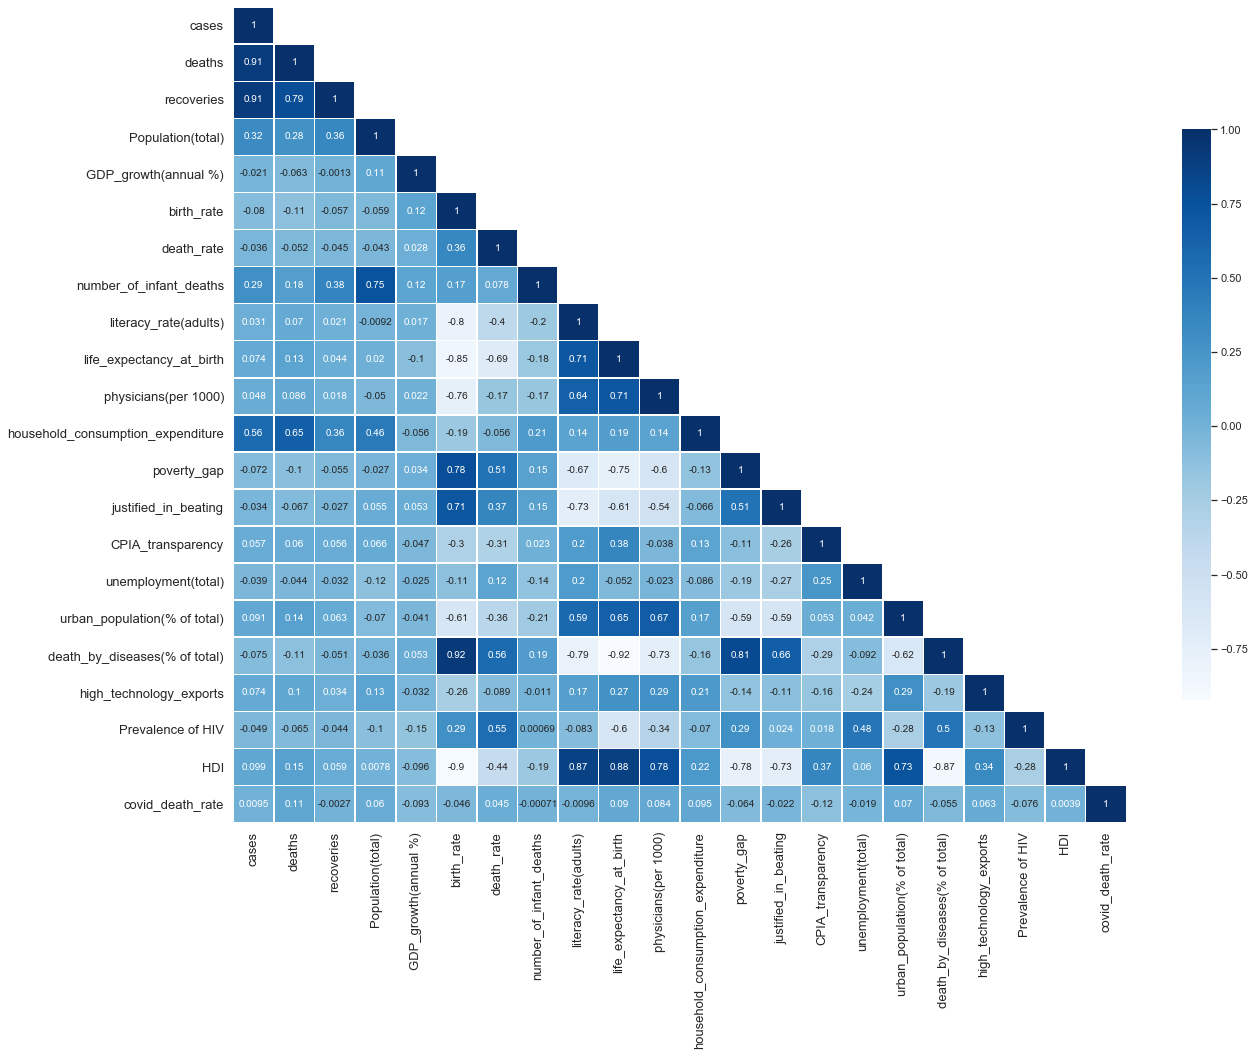

In [80]:
# Correlation
corr = df.corr()


# Correlation heatmap for numerical variables

# Lower triangle
corr_lower = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))

fig, ax = plt.subplots(figsize = (20,15))

ax = sns.heatmap(corr_lower, cmap = "Blues",annot = True, 
                 linewidths = 0.5, cbar_kws={"shrink": .7})

ax.tick_params(axis = "both", labelsize = 13)

### Visualizations

#### Deaths by Development Level

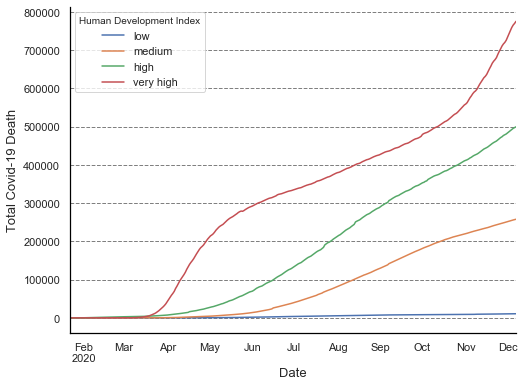

In [82]:
dev_data = df.groupby(["Date", "human_development_level"]).sum()
dev_data = dev_data[dev_data["deaths"].notna()]
dev_data = dev_data.pivot_table(index = "Date", columns = "human_development_level",
                                     values = "deaths", aggfunc = "sum")

# Plotting
plt.rcParams["figure.figsize"] = [8, 6]
dev_graph = dev_data.plot()

dev_graph.spines["right"].set_visible(False)
dev_graph.spines["top"].set_visible(False)

plt.xlabel("Date", size = 13)
plt.ylabel("Total Covid-19 Death", size = 13)
plt.legend(title = "Human Development Index")

dev_graph.set_axisbelow(True)
dev_graph.yaxis.grid(color = "gray", linestyle = "dashed")

As evident in the graph above, we can see the clear distinction between the growth pattern of total Covid-19 deaths for different levels of Human Development Index (HDI) across the world. This may imply that, we might be able to predict Covid-19 time-series patterns from different countries’ characteristics.

#### World Map of Deaths

In [32]:
country_data = df.groupby("Country").last()
country_data_deaths = country_data[["deaths"]].reset_index()
country_data_deaths = country_data_deaths.sort_values("deaths", ascending = False)
country_data_deaths.head()

,Country,deaths
177,US,284018
23,Brazil,177317
79,India,140958
114,Mexico,110074
181,United Kingdom,61531


Text(0.83, 0.055, 'Covid-19 Deaths')

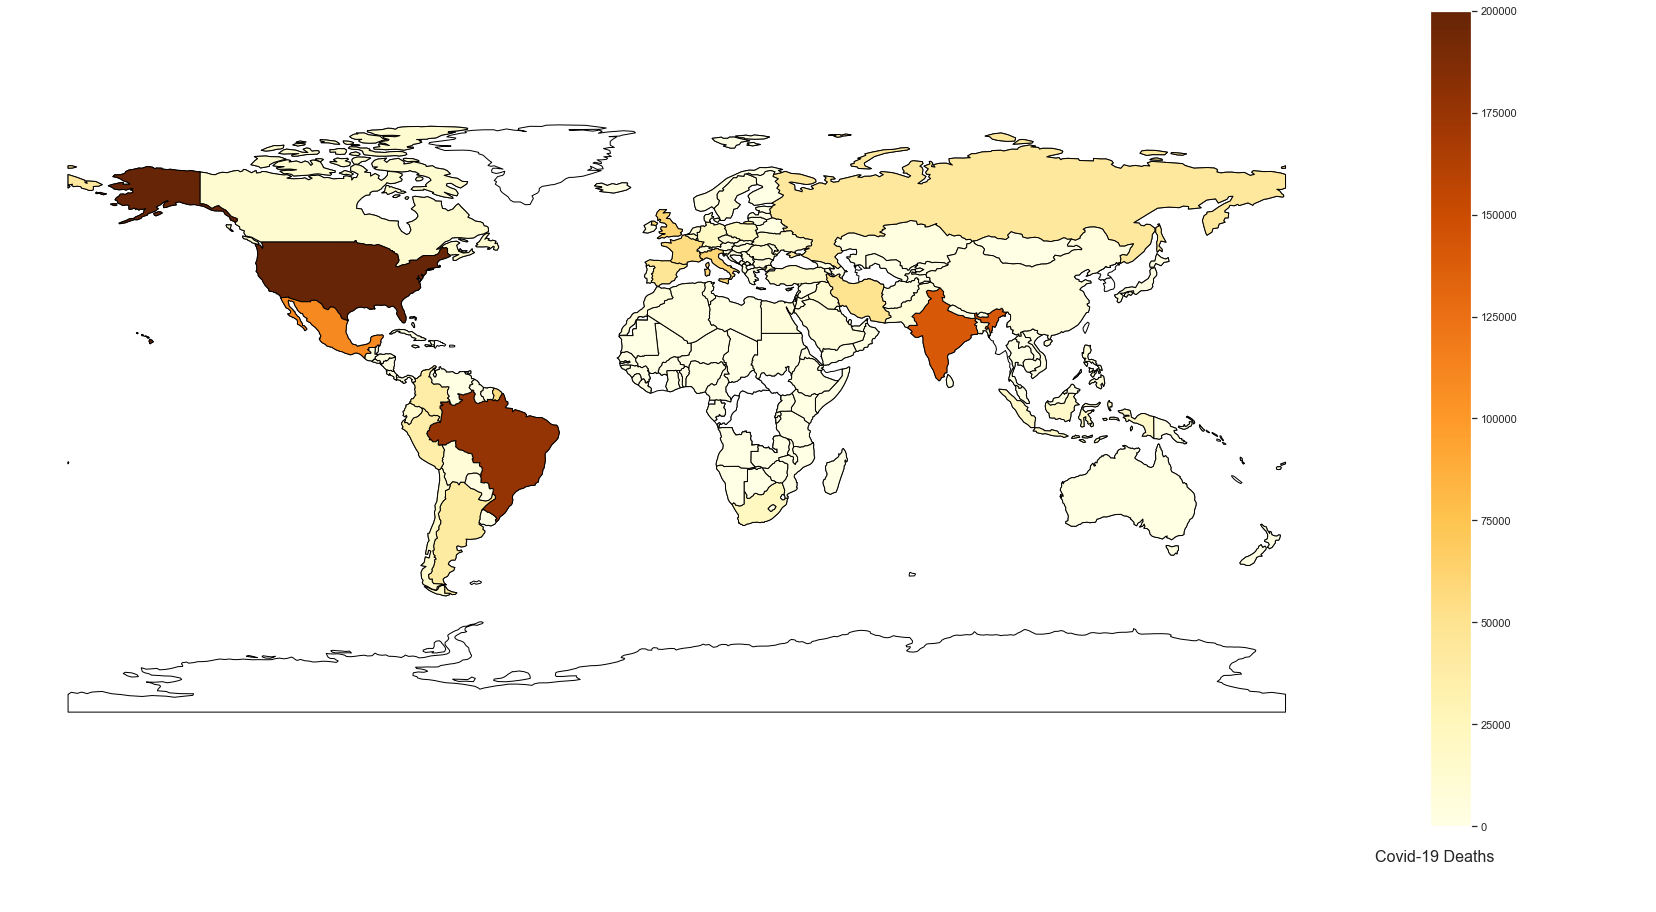

In [33]:
country_data_deaths.loc[country_data_deaths.Country == "US", "Country"] = "United States of America"
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world_data = world.merge(country_data_deaths, left_on = "name", right_on = "Country", how = "inner")

fig, ax = plt.subplots(figsize=(30,15))

# Plot the world
world.plot(ax=ax, edgecolor='black', color = "white")

world_data.plot(ax = ax, edgecolor = "black", column = "deaths", 
           legend = True, cmap = "YlOrBr", vmin = 0, vmax = 200000)

# turning off the axes
plt.axis("off")

# Adding text below the color bar
ax.annotate('Covid-19 Deaths',xy=(0.83, 0.055),  xycoords='figure fraction', size = 16)


The map above presents the world map of total Covid-19 deaths until December 7, 2020. From the map, we can see that the US is the country with the highest deaths in the world. From the world map, we can also tell that the countries with the highest deaths after the US are Brazil, India and Mexico respectively.

In addition to a world map, to establish some facts and patterns in the data, I have also graphed total Covid-19 deaths against some of the WDIs. The relationship between some of the indicators and the total deaths is presented in the graphs below. One thing to note is that, it is difficult to interpret these graphs and establish patterns, since countries like the US, Brazil, India and Mexico are the outliers in the graphs.

#### GDP Growth and deaths

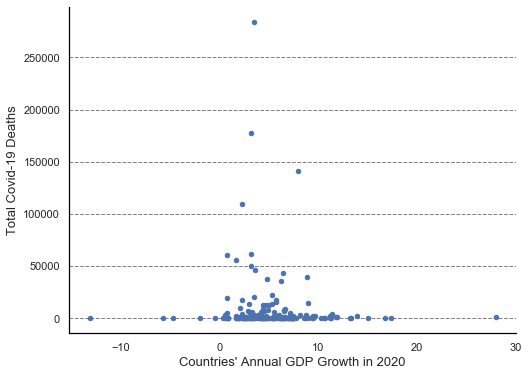

In [73]:
gdp_data = df.groupby("Country").agg({"deaths": "last",
                                      "GDP_growth(annual %)": "last"}).reset_index()

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.facecolor'] = 'white'
gdp_data_graph = gdp_data.plot(x = "GDP_growth(annual %)", y = "deaths", kind = "scatter")

gdp_data_graph.set_xlabel("Countries' Annual GDP Growth in 2020", size = 13)
gdp_data_graph.set_ylabel("Total Covid-19 Deaths", size = 13)

gdp_data_graph.spines["right"].set_visible(False)
gdp_data_graph.spines["top"].set_visible(False)

gdp_data_graph.set_axisbelow(True)
gdp_data_graph.yaxis.grid(color = "gray", linestyle = "dashed")




#### Household final consumption expenditure (PPP) and Deaths


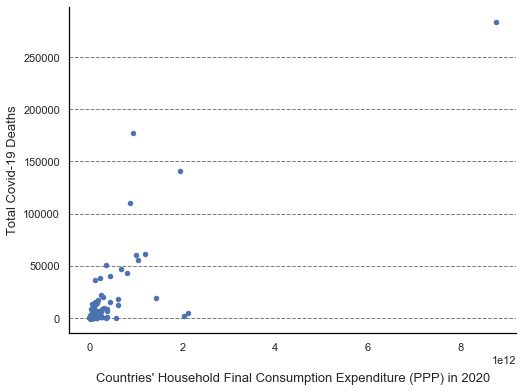

In [74]:
household_data = df.groupby("Country").agg({"deaths": "last",
                                      "household_consumption_expenditure": "last"}).reset_index()

plt.rcParams["figure.figsize"] = [8, 6]
household_data_graph = household_data.plot(x = "household_consumption_expenditure", y = "deaths", kind = "scatter")

household_data_graph.set_xlabel("Countries' Household Final Consumption Expenditure (PPP) in 2020", size = 13, labelpad = 20)
household_data_graph.set_ylabel("Total Covid-19 Deaths", size = 13)

household_data_graph.spines["right"].set_visible(False)
household_data_graph.spines["top"].set_visible(False)

household_data_graph.set_axisbelow(True)
household_data_graph.yaxis.grid(color = "gray", linestyle = "dashed")


#### Physicians (per 1,000 people) and Total Deaths

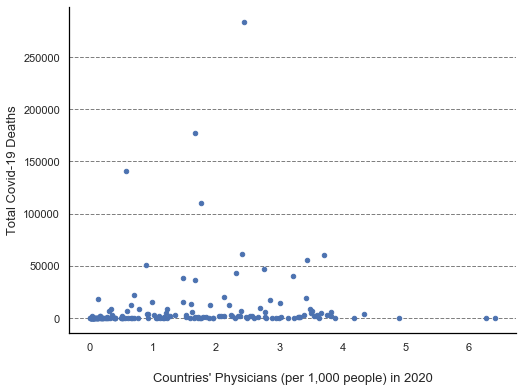

In [75]:
phys_data = df.groupby("Country").agg({"deaths": "last",
                                      "physicians(per 1000)": "last"}).reset_index()

plt.rcParams["figure.figsize"] = [8, 6]
phys_data_graph = phys_data.plot(x = "physicians(per 1000)", y = "deaths", kind = "scatter")

phys_data_graph.set_xlabel("Countries' Physicians (per 1,000 people) in 2020", size = 13, labelpad = 20)
phys_data_graph.set_ylabel("Total Covid-19 Deaths", size = 13)

phys_data_graph.spines["right"].set_visible(False)
phys_data_graph.spines["top"].set_visible(False)

phys_data_graph.set_axisbelow(True)
phys_data_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### High Technology Exports and Total Deaths

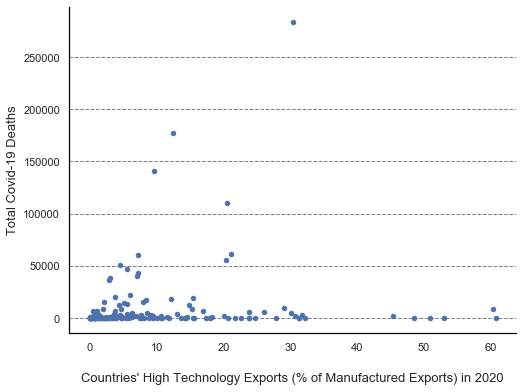

In [76]:
tech_data = df.groupby("Country").agg({"deaths": "last",
                                      "high_technology_exports": "last"}).reset_index()

plt.rcParams["figure.figsize"] = [8, 6]
tech_data_graph = tech_data.plot(x = "high_technology_exports", y = "deaths", kind = "scatter")

tech_data_graph.set_xlabel("Countries' High Technology Exports (% of Manufactured Exports) in 2020", size = 13, labelpad = 20)
tech_data_graph.set_ylabel("Total Covid-19 Deaths", size = 13)

tech_data_graph.spines["right"].set_visible(False)
tech_data_graph.spines["top"].set_visible(False)

tech_data_graph.set_axisbelow(True)
tech_data_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### Number of Infant Deaths and Covid-19 Deaths

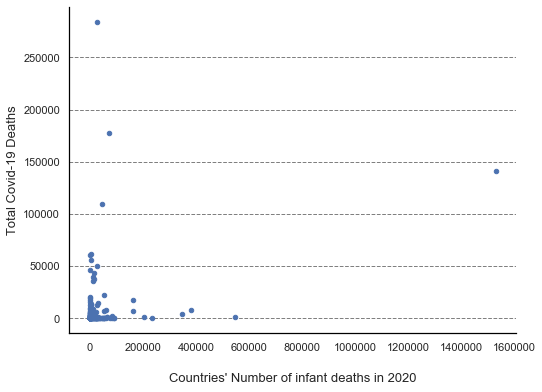

In [78]:
inf_data = df.groupby("Country").agg({"deaths": "last",
                                      "number_of_infant_deaths": "last"}).reset_index()

plt.rcParams["figure.figsize"] = [8, 6]
inf_data_graph = inf_data.plot(x = "number_of_infant_deaths", y = "deaths", kind = "scatter")

inf_data_graph.set_xlabel("Countries' Number of infant deaths in 2020", size = 13, labelpad = 20)
inf_data_graph.set_ylabel("Total Covid-19 Deaths", size = 13)

inf_data_graph.spines["right"].set_visible(False)
inf_data_graph.spines["top"].set_visible(False)

inf_data_graph.set_axisbelow(True)
inf_data_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### Urban Population and Covid-19 Deaths

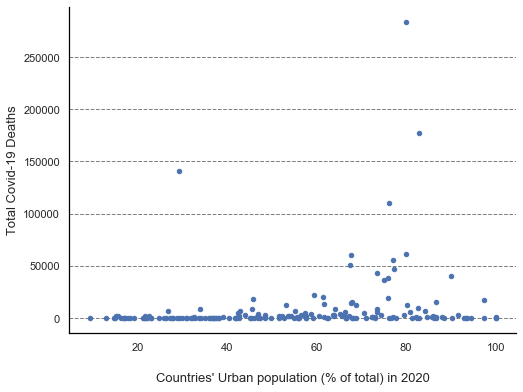

In [79]:
urb_data = df.groupby("Country").agg({"deaths": "last",
                                      "urban_population(% of total)": "last"}).reset_index()

plt.rcParams["figure.figsize"] = [8, 6]
urb_data_graph = urb_data.plot(x = "urban_population(% of total)", y = "deaths", kind = "scatter")

urb_data_graph.set_xlabel("Countries' Urban population (% of total) in 2020", size = 13, labelpad = 20)
urb_data_graph.set_ylabel("Total Covid-19 Deaths", size = 13)

urb_data_graph.spines["right"].set_visible(False)
urb_data_graph.spines["top"].set_visible(False)

urb_data_graph.set_axisbelow(True)
urb_data_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### Covid-19 Deaths for Different Countries

In [83]:
ind_data = df.groupby(["Country", "Date"], sort = True).sum()

In [84]:
ind_data = ind_data[["deaths"]].reset_index()
ind_data.columns = ["Country", "Date", "deaths"]

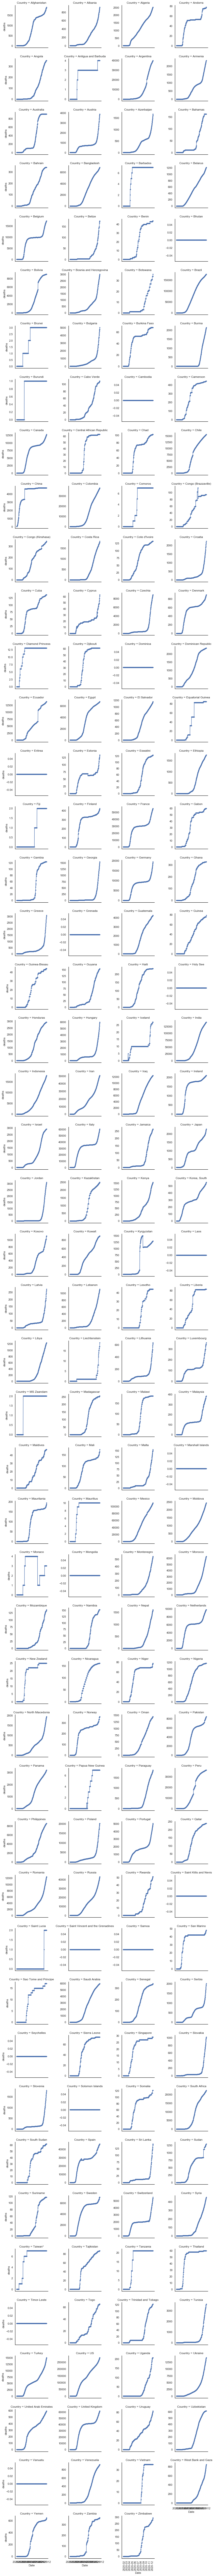

In [85]:
ind_data_graph = sns.FacetGrid(ind_data, col = "Country", col_wrap = 4, sharey = False)
ind_data_graph.map(plt.plot, "Date", "deaths", marker = ".")
plt.xticks(rotation = 90)
plt.show()

#### Average Covid Death Rates and Development Level

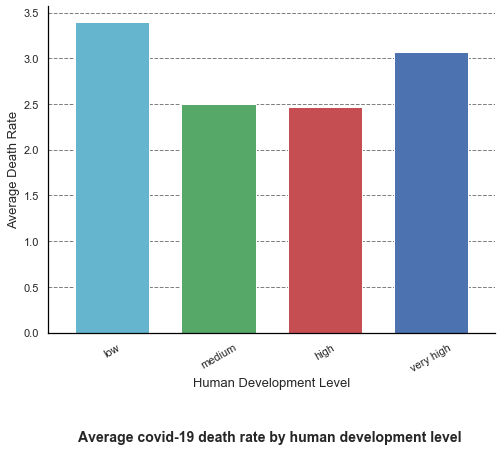

In [87]:
deaths_development = df.pivot_table("covid_death_rate", index = "human_development_level", aggfunc = "mean")
deaths_development.reset_index(level = 0, inplace = True)

# Plotting 
plt.rcParams["figure.figsize"] = [8, 6]
# Colors of the bars

colors = ["c", "g", "r", "b"]
deaths_development_graph = deaths_development.plot(x = "human_development_level", y = "covid_death_rate", kind = "bar",
                                                  width = 0.7, color = colors)

plt.xlabel("Human Development Level", size = 13)
plt.ylabel("Average Death Rate", size = 13)
plt.xticks(rotation = 30)

plt.title("Average covid-19 death rate by human development level ", 
          x = 0.5, y = -0.35,
          size = 14, fontweight = "bold")

deaths_development_graph.spines["right"].set_visible(False)
deaths_development_graph.spines["top"].set_visible(False)

# Removing the legend
deaths_development_graph.get_legend().remove()

deaths_development_graph.set_axisbelow(True)
deaths_development_graph.yaxis.grid(color = "gray", linestyle = "dashed")

## Analysis using LSTM

There are different algorithms to deal with time-series data, however a few of them could make a good model for time series panel data (Sarkar & Bruyn, 2020). Even though there are statistical models such as Random Effect, Fixed Effect, First Difference, Between estimation and pooled OLS models for dealing with panel data, they are based on linear models and linear methods can be difficult to adapt to multivariate or multiple-input forecasting problems. On the other hand, Long Short Term Memory (LSTM) networks seem to be particularly suited for multiple-input panel data analysis. They could be easily applied to panel data, and they do not rely on an analyst’s domain knowledge to give predictions with high accuracy. Moreover, they rely exclusively on raw data as input and often times result in models with high prediction accuracies (Sarkar & Bruyn, 2020).

### LSTM models

Long Short Term Memory (LSTM) networks are a type of recurrent neural networks that are capable of learning order dependence in sequence prediction problems. Unlike standard feedforward neural networks, LSTM has feedback connection. Moreover, LSTM models are able to store information over a period of time. This characteristic is extremely useful when dealing with time-series data. The LSTM models are able to decide what information will be stored and what information will be discarded. This is done by using “gates”. <br>

LSTMs are made up of 3 gates. The gates are input, forget and output gates. The sigmoid function is used for gates, and as it is evident from the sigmoid function graph below they would output a value between 0 and 1. In a lot of cases, the sigmoid activation function outputs a value of either 0 or 1. The gates are blocking everything if the output is 0, and the gates are allowing everything to pass through if the output is 1.


Sigmoid function:

$$
\begin{equation} 
\sigma(t) = \frac{1}{1 + e^{(-t)}} \tag{1}\label{eq:1} 
\end{equation}
$$


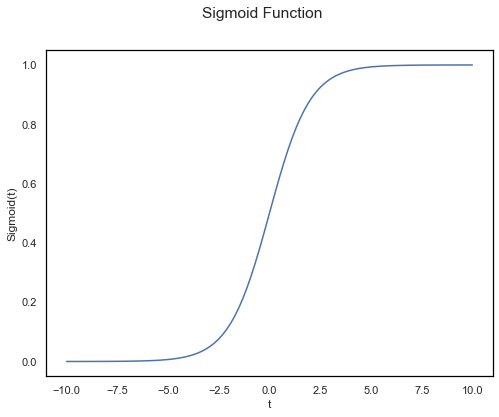

In [119]:
t = np.linspace(-10, 10, 100) 
z = 1/(1 + np.exp(-t)) 
fig = plt.figure()

plt.plot(t, z) 
plt.xlabel("t") 
plt.ylabel("Sigmoid(t)")
fig.suptitle('Sigmoid Function')
plt.rcParams['font.size']=13

The reason sigmoid function is used is because we want the gates to give only positive values and be clear in keeping or discarding a particular feature. The working procedure of the LSTM cell is also defined mathematically in equations 2-7. Below, I provide and explain the equations for LSTM.

Gate equations:\
Input gate:
$$ \begin{equation} 
i_{t} = \sigma(w_{i}[h_{t-1}, x_{t}] + b_{i}) \tag{2}\label{eq:2} 
\end{equation}
$$

Forget gate:
$$ \begin{equation} 
f_{t} = \sigma(w_{f}[h_{t-1}, x_{t}] + b_{f}) \tag{3}\label{eq:3} 
\end{equation} 
$$

Output gate:
$$ \begin{equation} 
o_{t} = \sigma(w_{o}[h_{t-1}, x_{t}] + b_{o}) \tag{4}\label{eq:4} 
\end{equation} 
$$
\
\
$$ 
\begin{equation}
\tilde{c_{t}} = tanh(w_{c}[h_{t-1}, x_{t}] + b_{c}) \tag{5}\label{eq:5} 
\end{equation}
$$
\
$$
\begin{equation}
c_{t} = f_{t} * c_{t-1} + i_{t} * \tilde{c_{t}} \tag{6}\label{eq:6} 
\end{equation}
$$
\
$$
\begin{equation}
h_{t} = o_{t} * tanh(c^t) \tag{7}\label{eq:7} 
\end{equation}
$$



Where: <br>
$i_{t}$ is the input gate. <br>
$f_{t}$ the forget gate. <br>
$o_{t}$ is the output gate. <br>
σ is the sigmoid function. <br>
$w_{i}$ is the weight for the input gate neurons. <br>
$w_{f}$ is the weight for the forget gate neurons. <br>
$w_{o}$ is the weight for the output gate neurons. <br>
$h_{t-1}$ is the output of the previous LSTM block. <br>
$x_{t}$ is the input at current timestamp. <br>
$b_{i}$ is the bias for the input gate. <br>
$b_{f}$ is the bias for the forget gate. <br>
$b_{o}$ is the bias for the output gate. <br>
$\tilde{c_{t}}$ is the candidate for the cell state. <br>
$c_{t}$ is the cell state.


Equation 2 tells us what new information is stored in the cell state. Equation 3 determines what information to be thrown away from the cell state, and equation 4 is used to provide the activation to the final output of the LSTM block at the current timestamp. Equation 5 represents candidates for the cell state, and equation 6 represents the cell state at the current timestamp. In more detail, we see that the first part of the equation 6 represents what the cell state needs to forget from the previous timestamp, and the second part of the equation 6 represents what the cell state needs to consider from the current timestamp. It is evident from the equation 7 that the cell state is filtered and passed through the activation function which predicts what portion should appear as the output of the current LSTM unit. Finally, the output from the current LSTM block can be passed through the Rectified Linear Units (ReLu) layer to obtain the predicted output from the current block. 

### Developing the model

In [227]:
# dropping unnecessary columns
data = df.drop(["HDI", "human_development_level", "covid_death_rate", "cases", "recoveries"], axis = 1).copy()
data.head()

,Country,Date,deaths,Population(total),GDP_growth(annual %),birth_rate,death_rate,number_of_infant_deaths,literacy_rate(adults),life_expectancy_at_birth,physicians(per 1000),household_consumption_expenditure,poverty_gap,justified_in_beating,CPIA_transparency,unemployment(total),urban_population(% of total),death_by_diseases(% of total),high_technology_exports,Prevalence of HIV
0,Afghanistan,2020-01-22,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1
1,Afghanistan,2020-01-23,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1
2,Afghanistan,2020-01-24,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1
3,Afghanistan,2020-01-25,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1
4,Afghanistan,2020-01-26,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,NaN,90.2,2.5,2.4945,22.703,50.2,NaN,0.1


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61311 entries, 0 to 61310
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Country                            61311 non-null  object        
 1   Date                               61311 non-null  datetime64[ns]
 2   deaths                             61311 non-null  int64         
 3   Population(total)                  57138 non-null  float64       
 4   GDP_growth(annual %)               56817 non-null  float64       
 5   birth_rate                         57138 non-null  float64       
 6   death_rate                         57138 non-null  float64       
 7   number_of_infant_deaths            56496 non-null  float64       
 8   literacy_rate(adults)              46866 non-null  float64       
 9   life_expectancy_at_birth           55854 non-null  float64       
 10  physicians(per 1000)              

### Dealing with missing values

In [135]:
# Backward Filling

data.loc[:,:] = data.groupby(["Country"]).bfill()

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61311 entries, 0 to 61310
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Country                            0 non-null      float64       
 1   Date                               61311 non-null  datetime64[ns]
 2   deaths                             61311 non-null  int64         
 3   Population(total)                  61311 non-null  float64       
 4   GDP_growth(annual %)               61311 non-null  float64       
 5   birth_rate                         61311 non-null  float64       
 6   death_rate                         61311 non-null  float64       
 7   number_of_infant_deaths            61311 non-null  float64       
 8   literacy_rate(adults)              61311 non-null  float64       
 9   life_expectancy_at_birth           61311 non-null  float64       
 10  physicians(per 1000)              

In [137]:
data["Country"] = df["Country"]
data.Country = data.Country.astype("str")

In [138]:
data.head()

,Country,Date,deaths,Population(total),GDP_growth(annual %),birth_rate,death_rate,number_of_infant_deaths,literacy_rate(adults),life_expectancy_at_birth,physicians(per 1000),household_consumption_expenditure,poverty_gap,justified_in_beating,CPIA_transparency,unemployment(total),urban_population(% of total),death_by_diseases(% of total),high_technology_exports,Prevalence of HIV
0,Afghanistan,2020-01-22,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,0.1,90.2,2.5,2.4945,22.703,50.2,1.328193,0.1
1,Afghanistan,2020-01-23,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,0.1,90.2,2.5,2.4945,22.703,50.2,1.328193,0.1
2,Afghanistan,2020-01-24,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,0.1,90.2,2.5,2.4945,22.703,50.2,1.328193,0.1
3,Afghanistan,2020-01-25,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,0.1,90.2,2.5,2.4945,22.703,50.2,1.328193,0.1
4,Afghanistan,2020-01-26,0,25654277.0,11.229715,44.723,10.003,85285.0,31.448851,58.29,0.1596,3.063953e+10,0.1,90.2,2.5,2.4945,22.703,50.2,1.328193,0.1


### Normalizing the data

In [139]:
# Normalizing the data
scaler = MinMaxScaler(feature_range = (0,1))
scale = scaler.fit_transform(data.drop(columns = ["Country", "Date", "deaths"]))

In [140]:
# Converting array to dataframe
data_scaled = pd.DataFrame(data = scale, columns = data.drop(columns = ["Country", "Date", "deaths"]).columns)

In [141]:
df_scaled = data.copy()
df_scaled[data_scaled.columns] = np.array(data_scaled)
df_scaled["country"] = list(df_scaled.Country)


In [142]:
df_scaled = df_scaled.set_index(["Country", "Date"])

In [143]:
df_scaled.head()

deaths  Population(total)  GDP_growth(annual %)  \
Country     Date                                                          
Afghanistan 2020-01-22       0           0.019656              0.592806   
            2020-01-23       0           0.019656              0.592806   
            2020-01-24       0           0.019656              0.592806   
            2020-01-25       0           0.019656              0.592806   
            2020-01-26       0           0.019656              0.592806   

                        birth_rate  death_rate  number_of_infant_deaths  \
Country     Date                                                          
Afghanistan 2020-01-22    0.837672    0.452001                 0.055759   
            2020-01-23    0.837672    0.452001                 0.055759   
            2020-01-24    0.837672    0.452001                 0.055759   
            2020-01-25    0.837672    0.452001                 0.055759   
            2020-01-26    0.837672    0.452001                 0.055759   

                        literacy_rate(adults)  life_expectancy_at_birth  \
Country     Date                                                          
Afghanistan 2020-01-22               0.103653                  0.367654   
            2020-01-23               0.103653                  0.367654   
            2020-01-24               0.103653                  0.367654   
            2020-01-25               0.103653                  0.367654   
            2020-01-26               0.103653                  0.367654   

                        physicians(per 1000)  \
Country     Date                               
Afghanistan 2020-01-22              0.023655   
            2020-01-23              0.023655   
            2020-01-24              0.023655   
            2020-01-25              0.023655   
            2020-01-26              0.023655   

                        household_consumption_expenditure  poverty_gap  \
Country     Date                                                         
Afghanistan 2020-01-22                           0.003489     0.002545   
            2020-01-23                           0.003489     0.002545   
            2020-01-24                           0.003489     0.002545   
            2020-01-25                           0.003489     0.002545   
            2020-01-26                           0.003489     0.002545   

                        justified_in_beating  CPIA_transparency  \
Country     Date                                                  
Afghanistan 2020-01-22                   1.0           0.333333   
            2020-01-23                   1.0           0.333333   
            2020-01-24                   1.0           0.333333   
            2020-01-25                   1.0           0.333333   
            2020-01-26                   1.0           0.333333   

                        unemployment(total)  urban_population(% of total)  \
Country     Date                                                            
Afghanistan 2020-01-22             0.053394                      0.147068   
            2020-01-23             0.053394                      0.147068   
            2020-01-24             0.053394                      0.147068   
            2020-01-25             0.053394                      0.147068   
            2020-01-26             0.053394                      0.147068   

                        death_by_diseases(% of total)  \
Country     Date                                        
Afghanistan 2020-01-22                       0.695714   
            2020-01-23                       0.695714   
            2020-01-24                       0.695714   
            2020-01-25                       0.695714   
            2020-01-26                       0.695714   

                        high_technology_exports  Prevalence of HIV  \
Country     Date                                                     
Afghanistan 2020-01-22                 0

In [144]:
df_scaled.describe()

,deaths,Population(total),GDP_growth(annual %),birth_rate,death_rate,number_of_infant_deaths,literacy_rate(adults),life_expectancy_at_birth,physicians(per 1000),household_consumption_expenditure,poverty_gap,justified_in_beating,CPIA_transparency,unemployment(total),urban_population(% of total),death_by_diseases(% of total),high_technology_exports,Prevalence of HIV
count,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000,61311.000000
mean,2981.983298,0.025949,0.450698,0.349446,0.393181,0.020845,0.747263,0.589783,0.229327,0.021849,0.166727,0.391844,0.465969,0.202508,0.501422,0.342042,0.160052,0.079243
std,15113.547878,0.099023,0.097165,0.272782,0.205685,0.082250,0.282592,0.234214,0.212899,0.080109,0.245379,0.296866,0.196331,0.173458,0.260237,0.337527,0.198003,0.186417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.001509,0.395329,0.096066,0.237658,0.000212,0.572880,0.419962,0.028305,0.001064,0.005089,0.092446,0.333333,0.084727,0.284800,0.067143,0.026397,0.000000
50%,35.000000,0.005627,0.447940,0.292772,0.352404,0.001604,0.864270,0.669843,0.178960,0.002920,0.061069,0.347238,0.500000,0.167260,0.513766,0.170000,0.089291,0.011952
75%,413.000000,0.016331,0.493607,0.566949,0.548321,0.014635,0.979697,0.757615,0.386412,0.015626,0.208651,0.655017,0.666667,0.253041,0.708712,0.704286,0.199164,0.055777
max,284018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [145]:
df_scaled.head()

deaths  Population(total)  GDP_growth(annual %)  \
Country     Date                                                          
Afghanistan 2020-01-22       0           0.019656              0.592806   
            2020-01-23       0           0.019656              0.592806   
            2020-01-24       0           0.019656              0.592806   
            2020-01-25       0           0.019656              0.592806   
            2020-01-26       0           0.019656              0.592806   

                        birth_rate  death_rate  number_of_infant_deaths  \
Country     Date                                                          
Afghanistan 2020-01-22    0.837672    0.452001                 0.055759   
            2020-01-23    0.837672    0.452001                 0.055759   
            2020-01-24    0.837672    0.452001                 0.055759   
            2020-01-25    0.837672    0.452001                 0.055759   
            2020-01-26    0.837672    0.452001                 0.055759   

                        literacy_rate(adults)  life_expectancy_at_birth  \
Country     Date                                                          
Afghanistan 2020-01-22               0.103653                  0.367654   
            2020-01-23               0.103653                  0.367654   
            2020-01-24               0.103653                  0.367654   
            2020-01-25               0.103653                  0.367654   
            2020-01-26               0.103653                  0.367654   

                        physicians(per 1000)  \
Country     Date                               
Afghanistan 2020-01-22              0.023655   
            2020-01-23              0.023655   
            2020-01-24              0.023655   
            2020-01-25              0.023655   
            2020-01-26              0.023655   

                        household_consumption_expenditure  poverty_gap  \
Country     Date                                                         
Afghanistan 2020-01-22                           0.003489     0.002545   
            2020-01-23                           0.003489     0.002545   
            2020-01-24                           0.003489     0.002545   
            2020-01-25                           0.003489     0.002545   
            2020-01-26                           0.003489     0.002545   

                        justified_in_beating  CPIA_transparency  \
Country     Date                                                  
Afghanistan 2020-01-22                   1.0           0.333333   
            2020-01-23                   1.0           0.333333   
            2020-01-24                   1.0           0.333333   
            2020-01-25                   1.0           0.333333   
            2020-01-26                   1.0           0.333333   

                        unemployment(total)  urban_population(% of total)  \
Country     Date                                                            
Afghanistan 2020-01-22             0.053394                      0.147068   
            2020-01-23             0.053394                      0.147068   
            2020-01-24             0.053394                      0.147068   
            2020-01-25             0.053394                      0.147068   
            2020-01-26             0.053394                      0.147068   

                        death_by_diseases(% of total)  \
Country     Date                                        
Afghanistan 2020-01-22                       0.695714   
            2020-01-23                       0.695714   
            2020-01-24                       0.695714   
            2020-01-25                       0.695714   
            2020-01-26                       0.695714   

                        high_technology_exports  Prevalence of HIV  \
Country     Date                                                     
Afghanistan 2020-01-22                 0

### Splitting the data into training and testing data

Since my data is a panel dataset, it is not reasonable to randomly split the data into training and testing data. Therefore, I have splitted the data for each country first and then combined each country’s training data as my final training data and similarly, I have combined each country’s testing data as my final testing data. 

In [146]:
# Code Source: https://melaniesoek0120.medium.com/covid-19-global-data-time-series-prediction-with-lstm-recurrent-neural-networks-f7825c4a1f6f
# 70% training and 30% testing
def train_test_split(data):
    size=int(len(data)*0.7)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train = data.drop(columns=['deaths']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['deaths']).iloc[size:]
    y_train = data['deaths'].iloc[0:size] 
    y_test = data['deaths'].iloc[size:] 
    return x_train, x_test, y_train, y_test

In [147]:
country = list(set(df_scaled.country))
# loop each station and collect train and test data 
X_train = []
X_test = []
Y_train = []
Y_test = []

for i in range(0,len(country)):
    data=df_scaled[df_scaled['country'] == country[i]]
    x_train, x_test, y_train, y_test = train_test_split(data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)


In [148]:
# concat each train data from each station 
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station 
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

### Data Preprocessing

After splitting the data, I have converted the time-series data to a supervised learning problem (i.e. converted a sequence to pairs of input and output sequences) and reshaped the data into a 3D format that is required by an LSTM model. The three dimensions of this input are samples, time steps and features respectively.

In [149]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [150]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])


In [151]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test = reshape_data(train_data,test_data)


### Designing the Model

To make sure the model is tuned, I have kept on altering the LSTM hyper-parameters and the proposed hyper-parameters are the parameters that have resulted in the lowest RMSPE value.

In [189]:
# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))


model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs = 60 ,batch_size = 30, verbose=0, validation_data=(x_test, y_test), 
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience= 30)],
                    shuffle = False)
                    

#callbacks = [EarlyStopping(monitor = 'val_loss', patience= 50)], shuffle=False

### Prediction on the Testing set

In [190]:
# make a prediction 
y_test_pre = model.predict(x_test)

In [191]:
y_test_pre.shape,y_test.shape

((18526, 1), (18526,))

In [192]:
len([i[0] for i in y_test_pre][1:]),len(y_test[:-1])

(18525, 18525)

In [193]:
pa = pd.DataFrame()
pa['Date']=X_test.reset_index().Date.iloc[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa.head()

,Date,Prediction,Actual Values
1,2020-09-03,34.677452,26.0
2,2020-09-04,34.677452,26.0
3,2020-09-05,34.677452,26.0
4,2020-09-06,35.711334,27.0
5,2020-09-07,35.711334,27.0


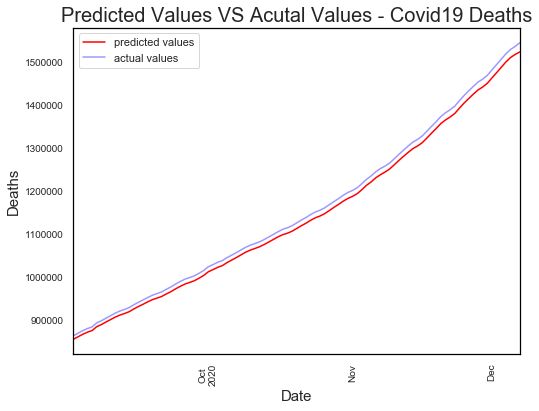

In [194]:

pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='predicted values',color='red',alpha=1)
pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=10)
plt.yticks(size=10)

plt.ylabel('Deaths',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.title('Predicted Values VS Acutal Values - Covid19 Deaths',fontsize=20)
plt.legend()

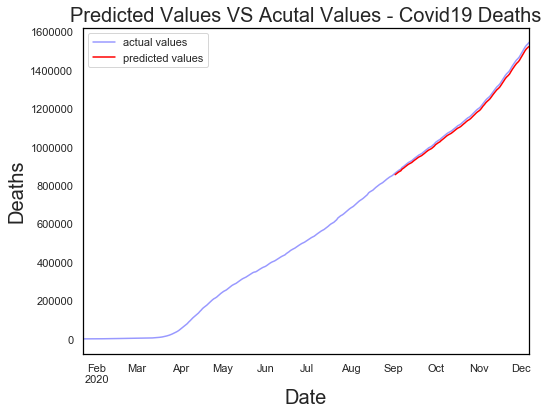

In [195]:
graph_data = df_scaled.reset_index().groupby("Date")["deaths"].sum()

graph_data.plot(kind='line',label='actual values',color='blue',alpha=0.4)
pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='predicted values',color='red',alpha=1)

plt.ylabel('Deaths',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - Covid19 Deaths',fontsize=20)
plt.legend()


#### RMSPE 

$$
\begin{equation} 
RMSPE = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_{i} - \hat y_{i})^2} \tag{8}\label{eq:8} 
\end{equation}
$$

In [196]:
# RMSPE
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

print("RMSPE is:")
print(RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:]))

RMSPE is:
474.83482403736105


As evident from equation 8, a key feature of the formula for RMSPE is the squared difference between the observed target variable and the prediction target value for each observation on unseen data. If the predictions are very close to the true value, then the RMSPE will be small, and on the other hand of the predictions are substantially different from the true values, then the RMSPE will be quite large. <br>

It is worth mentioning that RMSPE has the useful property of being in the same units as the response variable. In our context, the target variable is the “number of deaths”, and therefore the RMSPE has the same unit of “number of deaths”. As mentioned in the introduction, there have been a total of 1,544,532 deaths reported throughout the world until December 7, 2020. Considering that the total number of world Covid-19 deaths is in millions, an RMSPE value of 474.83 deaths is a relatively very small number. 

### Prediction on the training set

In [199]:
# make a prediction 
y_train_pre = model.predict(x_train)

In [200]:
y_train_pre.shape,y_train.shape

((42783, 1), (42783,))

In [201]:
len([i[0] for i in y_train_pre][1:]),len(y_train[:-1])

(42782, 42782)

In [202]:
pa_train = pd.DataFrame()
pa_train['Date']=X_train.reset_index().Date.iloc[1:-1]
pa_train['Prediction']=[i[0] for i in y_train_pre][1:] 
pa_train['Actual Values']=y_train[:-1]
pa_train.head()

,Date,Prediction,Actual Values
1,2020-01-23,7.79723,0.0
2,2020-01-24,7.79723,0.0
3,2020-01-25,7.79723,0.0
4,2020-01-26,7.79723,0.0
5,2020-01-27,7.79723,0.0


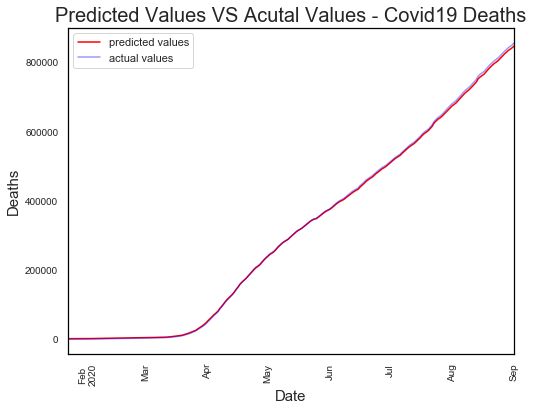

In [203]:
pa_train.groupby('Date')['Prediction'].sum().plot(kind='line',label='predicted values',color='red',alpha=1)
pa_train.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=10)
plt.yticks(size=10)

plt.ylabel('Deaths',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.title('Predicted Values VS Acutal Values - Covid19 Deaths',fontsize=20)
plt.legend()

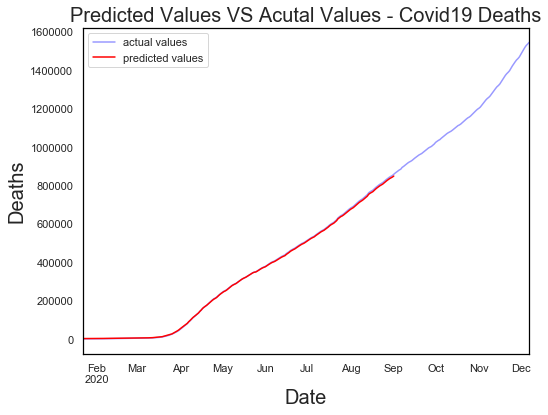

In [204]:
graph_data_train = df_scaled.reset_index().groupby("Date")["deaths"].sum()

graph_data_train.plot(kind='line',label='actual values',color='blue',alpha=0.4)
pa_train.groupby('Date')['Prediction'].sum().plot(kind='line',label='predicted values',color='red',alpha=1)

plt.ylabel('Deaths',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - Covid19 Deaths',fontsize=20)
plt.legend()

In [205]:
print("RMSE is:")
print(RMSE(y_train[:-1],[i[0] for i in y_train_pre][1:]))

RMSE is:
181.69316016414382


We see that the RMSPE on the testing data is higher than the RMSE on the training data, implying that the LSTM model has performed better on the training data. This could imply that the model is in fact overfitting.

## Forecasting World Covid-19 Total Deaths

In [219]:
df1 = df_scaled.reset_index()
df1 = df1.groupby("Date").sum()
df1 = df1.reset_index()
df1.head()

,Date,deaths,Population(total),GDP_growth(annual %),birth_rate,death_rate,number_of_infant_deaths,literacy_rate(adults),life_expectancy_at_birth,physicians(per 1000),household_consumption_expenditure,poverty_gap,justified_in_beating,CPIA_transparency,unemployment(total),urban_population(% of total),death_by_diseases(% of total),high_technology_exports,Prevalence of HIV
0,2020-01-22,17,4.956178,86.083304,66.744229,75.097629,3.981352,142.727205,112.64846,43.801411,4.173193,31.844784,74.842165,89.0,38.679045,95.771553,65.33,30.569852,15.135458
1,2020-01-23,18,4.956178,86.083304,66.744229,75.097629,3.981352,142.727205,112.64846,43.801411,4.173193,31.844784,74.842165,89.0,38.679045,95.771553,65.33,30.569852,15.135458
2,2020-01-24,26,4.956178,86.083304,66.744229,75.097629,3.981352,142.727205,112.64846,43.801411,4.173193,31.844784,74.842165,89.0,38.679045,95.771553,65.33,30.569852,15.135458
3,2020-01-25,42,4.956178,86.083304,66.744229,75.097629,3.981352,142.727205,112.64846,43.801411,4.173193,31.844784,74.842165,89.0,38.679045,95.771553,65.33,30.569852,15.135458
4,2020-01-26,56,4.956178,86.083304,66.744229,75.097629,3.981352,142.727205,112.64846,43.801411,4.173193,31.844784,74.842165,89.0,38.679045,95.771553,65.33,30.569852,15.135458


In [220]:
df1["Date"] = pd.to_datetime(df1["Date"])
df1.set_axis(df1["Date"], inplace = True)


death_data = df1["deaths"].values
death_data = death_data.reshape((-1,1))

split_percent = 0.7
split = int(split_percent*len(df1))

death_train = death_data[:split]
death_test = death_data[split:]

date_train = df1['Date'][:split]
date_test = df1['Date'][split:]

In [221]:
# source: https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816

### Model
look_back = 5

train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(death_train, death_train, length=look_back, batch_size=30)     
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(death_test, death_test, length=look_back, batch_size=1)

model = Sequential()
model.add(
    LSTM(60,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 60
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/60
8/8 [==============================] - 0s 4ms/step - loss: 209638440960.0000
Epoch 2/60
8/8 [==============================] - 0s 4ms/step - loss: 200837365760.0000
Epoch 3/60
8/8 [==============================] - 0s 4ms/step - loss: 181788590080.0000
Epoch 4/60
8/8 [==============================] - 0s 4ms/step - loss: 138586324992.0000
Epoch 5/60
8/8 [==============================] - 0s 4ms/step - loss: 119874379776.0000
Epoch 6/60
8/8 [==============================] - 0s 4ms/step - loss: 107029479424.0000
Epoch 7/60
8/8 [==============================] - 0s 4ms/step - loss: 75663376384.0000
Epoch 8/60
8/8 [==============================] - 0s 5ms/step - loss: 63639654400.0000
Epoch 9/60
8/8 [==============================] - 0s 3ms/step - loss: 38953320448.0000
Epoch 10/60
8/8 [==============================] - 0s 4ms/step - loss: 12023615488.0000
Epoch 11/60
8/8 [==============================] - 0s 5ms/step - loss: 10159086592.0000
Epoch 12/60
8/8 [==================

In [222]:
prediction = model.predict_generator(test_generator)

death_train = death_train.reshape((-1))
death_test = death_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = death_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = death_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Covid-19 Deaths",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Deaths"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [223]:
### Forecasting
death_data = death_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = death_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df1['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 60
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [224]:
### Plotting
prediction = model.predict_generator(test_generator)

death_train = death_train.reshape((-1))
death_test = death_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = death_train,
    mode = 'lines',
    name = 'Training Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecast'
)
trace3 = go.Scatter(
    x = date_test,
    y = death_test,
    mode='lines',
    name = 'Testing Data'
)
layout = go.Layout(
    title = "Covid 19 Deaths Forecast For the Next Two Months",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Death"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

### Forecasting for Selected Countries With Good Response to Covid

In [232]:
good_countries = np.array(["Haiti", "Singapore", "Thailand", "China"])
good_countries = pd.Series(good_countries)
good_countries

0        Haiti
1    Singapore
2     Thailand
3        China
dtype: object

In [243]:
for i in range(len(good_countries)):
    
    country = data[data.Country == good_countries[i]]
    country["Date"] = pd.to_datetime(country["Date"])
    country.set_axis(country["Date"], inplace = True)
    
    country_death_data = country["deaths"].values
    country_death_data = country_death_data.reshape((-1,1))
    
    split_percent = 0.7
    split = int(split_percent*len(country_death_data))
    
    country_death_train = country_death_data[:split]
    country_death_test = country_death_data[split:]

    country_date_train = country['Date'][:split]
    country_date_test = country['Date'][split:]
    
    ### Model
    look_back = 2

    country_train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(country_death_train, country_death_train, length=look_back, batch_size=50)     
    country_test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(country_death_test, country_death_test, length=look_back, batch_size=1)
    
    country_model = Sequential()
    country_model.add(
    LSTM(60,
        activation='relu',
        input_shape=(look_back,1))
    )
    country_model.add(Dense(1))
    country_model.compile(optimizer='adam', loss='mse')

    num_epochs = 50
    country_model.fit_generator(country_train_generator, epochs=num_epochs, verbose=0)
    
    country_prediction = country_model.predict_generator(country_test_generator)

    country_death_train = country_death_train.reshape((-1))
    country_death_test = country_death_test.reshape((-1))
    country_prediction = country_prediction.reshape((-1))

    trace1 = go.Scatter(
        x = country_date_train,
        y = country_death_train,
        mode = 'lines',
        name = 'Data'
    )
    trace2 = go.Scatter(
        x = country_date_test,
        y = country_prediction,
        mode = 'lines',
        name = 'Prediction'
    )
    trace3 = go.Scatter(
        x = country_date_test,
        y = country_death_test,
        mode ='lines',
        name = 'Testing Data'
    )
    layout = go.Layout(
        title = "Covid 19 Deaths in {}".format(good_countries[i]),
        xaxis = {'title' : "Date"},
        yaxis = {'title' : "Deaths"}
    )
    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    fig.show()
    
    
    ### Forecasting
    country_death_data = country_death_data.reshape((-1))
    
    def predict(num_prediction, model):
        country_prediction_list = country_death_data[-look_back:]
    
        for _ in range(num_prediction):
            x = country_prediction_list[-look_back:]
            x = x.reshape((1, look_back, 1))
            out = country_model.predict(x)[0][0]
            country_prediction_list = np.append(country_prediction_list, out)
        country_prediction_list = country_prediction_list[look_back-1:]
        
        return country_prediction_list

    def predict_dates(num_prediction):
        last_date = country['Date'].values[-1]
        country_prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
        return country_prediction_dates
    
    num_prediction = 60
    country_forecast = predict(num_prediction, country_model)
    country_forecast_dates = predict_dates(num_prediction)
    
    
    ### Plotting
    country_prediction = country_model.predict_generator(country_test_generator)

    country_death_train = country_death_train.reshape((-1))
    country_death_test = country_death_test.reshape((-1))
    country_prediction = country_prediction.reshape((-1))

    trace1 = go.Scatter(
        x = country_date_train,
        y = country_death_train,
        mode = 'lines',
        name = 'Training Data'
    )
    trace2 = go.Scatter(
        x = country_forecast_dates,
        y = country_forecast,
        mode = 'lines',
        name = 'Forecast'
    )
    trace3 = go.Scatter(
        x = country_date_test,
        y = country_death_test,
        mode ='lines',
        name = 'Testing Data'
    )
    layout = go.Layout(
        title = "Covid 19 Deaths for the Next Two Months in {}".format(good_countries[i]),
        xaxis = {'title' : "Date"},
        yaxis = {'title' : "Death"}
    )
    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    fig.show()

/Users/anahitaainy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Forecasting for Countries that Need to Take Action 

In [244]:
summ = data.groupby("Country").sum()
summ.sort_values(by = "deaths", ascending = False).head()

,deaths,Population(total),GDP_growth(annual %),birth_rate,death_rate,number_of_infant_deaths,literacy_rate(adults),life_expectancy_at_birth,physicians(per 1000),household_consumption_expenditure,poverty_gap,justified_in_beating,CPIA_transparency,unemployment(total),urban_population(% of total),death_by_diseases(% of total),high_technology_exports,Prevalence of HIV
Country,,,,,,,,,,,,,,,,,,
US,39181199,9.486083e+10,1127.741628,4494.000,2664.300,8914170.0,0.000000,24873.585366,781.8276,2.807825e+15,256.8,0.0,0.0,1631.803471,25656.888,1733.4,9749.806584,128.4
Brazil,22599762,5.974680e+10,1027.884173,5535.003,1937.877,22747665.0,28766.487785,23078.616000,534.8823,2.971536e+14,995.1,0.0,0.0,3071.231824,26589.714,4333.5,4001.122810,160.5
India,13680218,3.683828e+11,2543.421230,7731.927,2591.754,490976883.0,20144.185135,20704.500000,184.8318,6.264107e+14,2407.5,15151.2,1123.5,777.237279,9384.435,10593.0,3106.695236,0.0
Mexico,12183296,3.402767e+10,740.806068,6978.861,1538.232,14354799.0,29413.317284,24171.300000,566.5971,2.754341e+14,706.2,0.0,0.0,1142.085885,24494.868,3563.1,6609.412717,0.0
United Kingdom,9849302,1.938879e+10,1020.692975,3852.000,3081.600,1180638.0,0.000000,25374.658537,774.2520,3.807404e+14,96.3,0.0,0.0,1524.846278,25652.715,2343.3,6774.044805,0.0


In [248]:
bad_countries = np.array(["US", "Brazil", "India", "Mexico"])
bad_countries = pd.Series(bad_countries)
bad_countries

0        US
1    Brazil
2     India
3    Mexico
dtype: object

In [262]:
for i in range(len(bad_countries)):
    
    country = data[data.Country == bad_countries[i]]
    country["Date"] = pd.to_datetime(country["Date"])
    country.set_axis(country["Date"], inplace = True)
    
    country_death_data = country["deaths"].values
    country_death_data = country_death_data.reshape((-1,1))
    
    split_percent = 0.7
    split = int(split_percent*len(country_death_data))
    
    country_death_train = country_death_data[:split]
    country_death_test = country_death_data[split:]

    country_date_train = country['Date'][:split]
    country_date_test = country['Date'][split:]
    
    ### Model
    look_back = 3

    country_train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(country_death_train, country_death_train, length=look_back, batch_size=30)     
    country_test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(country_death_test, country_death_test, length=look_back, batch_size=1)
    
    country_model = Sequential()
    country_model.add(
    LSTM(60,
        activation='relu',
        input_shape=(look_back,1))
    )
    country_model.add(Dense(1))
    country_model.compile(optimizer='adam', loss='mse')

    num_epochs = 50
    country_model.fit_generator(country_train_generator, epochs=num_epochs, verbose=0)
    
    country_prediction = country_model.predict_generator(country_test_generator)

    country_death_train = country_death_train.reshape((-1))
    country_death_test = country_death_test.reshape((-1))
    country_prediction = country_prediction.reshape((-1))

    trace1 = go.Scatter(
        x = country_date_train,
        y = country_death_train,
        mode = 'lines',
        name = 'Data'
    )
    trace2 = go.Scatter(
        x = country_date_test,
        y = country_prediction,
        mode = 'lines',
        name = 'Prediction'
    )
    trace3 = go.Scatter(
        x = country_date_test,
        y = country_death_test,
        mode ='lines',
        name = 'Testing Data'
    )
    layout = go.Layout(
        title = "Covid 19 Deaths in {}".format(bad_countries[i]),
        xaxis = {'title' : "Date"},
        yaxis = {'title' : "Deaths"}
    )
    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    fig.show()
    
    
    ### Forecasting
    country_death_data = country_death_data.reshape((-1))
    
    def predict(num_prediction, model):
        country_prediction_list = country_death_data[-look_back:]
    
        for _ in range(num_prediction):
            x = country_prediction_list[-look_back:]
            x = x.reshape((1, look_back, 1))
            out = country_model.predict(x)[0][0]
            country_prediction_list = np.append(country_prediction_list, out)
        country_prediction_list = country_prediction_list[look_back-1:]
        
        return country_prediction_list

    def predict_dates(num_prediction):
        last_date = country['Date'].values[-1]
        country_prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
        return country_prediction_dates
    
    num_prediction = 60
    country_forecast = predict(num_prediction, country_model)
    country_forecast_dates = predict_dates(num_prediction)
    
    
    ### Plotting
    country_prediction = country_model.predict_generator(country_test_generator)

    country_death_train = country_death_train.reshape((-1))
    country_death_test = country_death_test.reshape((-1))
    country_prediction = country_prediction.reshape((-1))

    trace1 = go.Scatter(
        x = country_date_train,
        y = country_death_train,
        mode = 'lines',
        name = 'Training Data'
    )
    trace2 = go.Scatter(
        x = country_forecast_dates,
        y = country_forecast,
        mode = 'lines',
        name = 'Forecast'
    )
    trace3 = go.Scatter(
        x = country_date_test,
        y = country_death_test,
        mode ='lines',
        name = 'Testing Data'
    )
    layout = go.Layout(
        title = "Covid 19 Deaths for the Next Two Months in {}".format(bad_countries[i]),
        xaxis = {'title' : "Date"},
        yaxis = {'title' : "Death"}
    )
    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    fig.show()

/Users/anahitaainy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Robustness checks

A difficulty with LSTM neural networks is that the results are different with different starting condition. This is because neural networks are stochastic, meaning that they make use of randomness such as initializing to random weights. This in turn can cause the same neural network trained on the same data to give different results each time the model is restarted. Therefore, to make sure that the resulting RMSPE and RMSE are robust, I repeat the experiment 30 times and take the average RMSPE and RMSE as an indication of how well the LSTM model performs on average.

#### Testing Data set

In [1356]:
repeats = 30
error_list = list()

for r in range(repeats):
    # design network for confirmed cases data 
    model = Sequential()
    model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))

    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    history = model.fit(x_train, y_train, epochs = 50 ,batch_size = 30, verbose=0, validation_data=(x_test, y_test), 
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience= 30)], shuffle=False)
    
    
    # make a prediction 
    y_test_pre = model.predict(x_test)
    
    def RMSE(actual,prediction):
        rmse = np.sqrt(mean_squared_error(actual,prediction))
        return rmse
    
    rmspe = RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:])
    
    print('%d) RMSPE: %.3f' % (r+1, rmspe))
    error_list.append(rmspe)
    
    

1) RMSPE: 462.761
2) RMSPE: 648.976
3) RMSPE: 1179.978
4) RMSPE: 519.305
5) RMSPE: 371.625
6) RMSPE: 344.478
7) RMSPE: 1377.277
8) RMSPE: 425.054
9) RMSPE: 599.688
10) RMSPE: 555.126
11) RMSPE: 330.985
12) RMSPE: 370.519
13) RMSPE: 292.880
14) RMSPE: 370.929
15) RMSPE: 383.731
16) RMSPE: 393.277
17) RMSPE: 371.155
18) RMSPE: 360.242
19) RMSPE: 384.434
20) RMSPE: 466.380
21) RMSPE: 9877.018
22) RMSPE: 318.268
23) RMSPE: 122.050
24) RMSPE: 403.530
25) RMSPE: 324.515
26) RMSPE: 391.917
27) RMSPE: 362.377
28) RMSPE: 343.353
29) RMSPE: 8066.546
30) RMSPE: 426.466


        RMSPE
count   30.00
mean   621.53
std    591.98
min    127.95
25%    427.86
50%    470.71
75%    518.80
max   2794.01


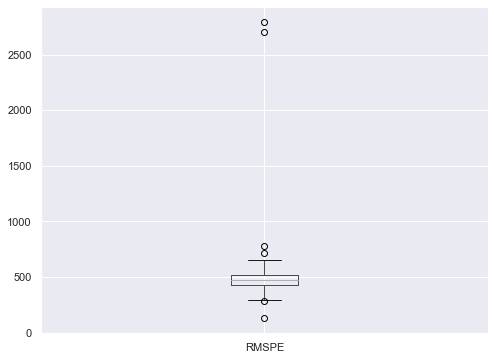

In [764]:
### Change
multiple_results = pd.DataFrame()
multiple_results['RMSPE'] = error_list
print(multiple_results.describe())
multiple_results.boxplot()
pyplot.show()


#### Training Dataset

In [1407]:
repeats2 = 30
error_list2 = list()

for r in range(repeats2):
    
    # Design network for deaths
    model = Sequential()
    model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))

    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    history = model.fit(x_train, y_train, epochs = 50 ,batch_size = 30, verbose=0, validation_data=(x_test, y_test), 
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience= 30)], shuffle=False)
    
    # Make a prediction
    y_train_pre = model.predict(x_train)
    
    def RMSE(actual,prediction):
        rmse = np.sqrt(mean_squared_error(actual,prediction))
        return rmse
    
    rmse = RMSE(y_train[:-1],[i[0] for i in y_train_pre][1:])
    
    print('%d) RMSE: %.3f' % (r+1, rmse))
    error_list2.append(rmse)
    
    

1) RMSE: 92.533
2) RMSE: 526.704
3) RMSE: 130.899
4) RMSE: 167.863
5) RMSE: 111.961
6) RMSE: 102.231
7) RMSE: 124.557
8) RMSE: 146.254
9) RMSE: 158.470
10) RMSE: 153.467
11) RMSE: 147.272
12) RMSE: 154.274
13) RMSE: 125.628
14) RMSE: 203.083
15) RMSE: 151.236
16) RMSE: 129.781
17) RMSE: 129.467
18) RMSE: 123.335
19) RMSE: 781.282
20) RMSE: 142.041
21) RMSE: 96.185
22) RMSE: 145.811
23) RMSE: 125.783
24) RMSE: 2833.059
25) RMSE: 839.781
26) RMSE: 136.161
27) RMSE: 102.758
28) RMSE: 132.115
29) RMSE: 121.659
30) RMSE: 153.109


         RMSE
count   30.00
mean   282.96
std    515.46
min     92.53
25%    124.82
50%    139.10
75%    154.07
max   2833.06


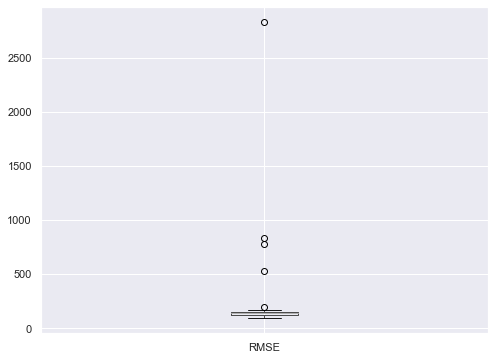

In [1410]:
results2 = pd.DataFrame()
results2['RMSE'] = error_list2
print(results2.describe())
results2.boxplot()
pyplot.show()

The average RMSPE of the model is 621.53, and the standard deviation is 591.98. Furthermore, the average RMSE is 282.96, and the standard deviation is 515.46. The results are helpful, as they suggest that the RMSPE value of 474.83 is very close to the average RMSPE of 621.53. Likewise, the RMSE value of 181.69 is very close to the average RMSE of 282.96.

## Conclusion and Future Work

As the number of Covid-19 cases around the globe is exponentially increasing, forecasting becomes an essential tool for providing guidance for prevention strategies. Since the countries around the world are structurally diverse, it is important to consider unique country characteristics while making forecasting models (Nikolopoulos et al., 2020). In this project, I have combined the Covid-19 data and World Development Indicator data from January 22, 2020 to December 7, 2020 to analyze the statistical power of WDIs in forecasting Covid-19. I have found that the performance error of Covid-19 predictions using WDIs is quite small, and therefore WDIs could be useful in predicting Covid-19 deaths. <br>

The forecasting model made in this paper uses the current projections only and does not take into account the external changes in circumstances and policies. Therefore, for future work, this model can be extended to account for vaccine development, universal masking, different reopening strategies, governmental decisions, etc. <br>

One last thing to mention is that the neural network based predictive models heavily depend on the quality of the data to make predictions. Some of the WDIs for some countries contain missing values. To improve the accuracy of the model, I call for all countries to provide their WDI data to the World Bank.

## References

Johns Hopkins University. (2020). COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University. Retrieved from https://github.com/CSSEGISandData/COVID-19 <br>

McGranahan, D. (1972). Development indicators and development models. The Journal of Development Studies, 8(3), 91-102. doi:10.1080/00220387208421414 <br>

Nikolopoulos, K., Punia, S., Schäfers, A., Tsinopoulos, C., & Vasilakis, C. (2020). Forecasting and planning during a pandemic: COVID-19 growth rates, supply chain disruptions, and governmental decisions. European Journal of Operational Research. doi:10.1016/j.ejor.2020.08.001 <br>

Sarkar, M., & Bruyn, A. D. (2020). LSTM Response Models for Direct Marketing Analytics: Replacing Feature Engineering with Deep Learning. SSRN Electronic Journal. doi:10.2139/ssrn.3601025